# Introduction to sentiment analysis with NLI

In this notebook, you will implement a sentiment scoring pipeline using a Natural Language Inference (NLI) model.
You will analyze whether news headlines about S&P 500 companies have positive or negative sentiment and explore how this sentiment correlates with market returns.


## Install and Import librairies
Install necessary packages and import the required libraries for:
- Loading data
- Using transformer models
- Plotting and visualizing results
- Downloading financial data

In [1]:
%pip install hf_xet
%pip install yfinance

In [2]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import math
import matplotlib.pyplot as plt
import yfinance as yf

## Load news data
Load two datasets:
- `df_news.csv`: contains headlines and summaries
- `df_metadata.csv`: contains ticker symbols and company sector info

We drop duplicate summaries to avoid redundant sentiment scoring.

In [3]:
df_news = pd.read_csv('./data/df_news.csv')
df_news.drop_duplicates('SUMMARY', inplace=True)
display(df_news)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29 04:33:58+00:00,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27 04:34:42+00:00,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22 14:08:00+00:00,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22 03:31:21+00:00,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19 04:41:32+00:00,StockStory,https://finance.yahoo.com/news/3-cash-producin...
...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23 10:30:00+00:00,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22 17:49:43+00:00,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21 18:14:38+00:00,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21 16:00:08+00:00,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...


In [4]:
df_meta = pd.read_csv('./data/df_metadata.csv')
display(df_meta)

,TICKER,COMPANY_NAME,SECTOR,INDUSTRY
0,MMM,3M Company,Industrials,Conglomerates
1,AOS,A. O. Smith Corporation,Industrials,Specialty Industrial Machinery
2,ABT,Abbott Laboratories,Healthcare,Medical Devices
3,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General
4,ACN,Accenture plc,Technology,Information Technology Services
...,...,...,...,...
485,XEL,Xcel Energy Inc.,Utilities,Utilities - Regulated Electric
486,XYL,Xylem Inc.,Industrials,Specialty Industrial Machinery
487,YUM,"Yum! Brands, Inc.",Consumer Cyclical,Restaurants
488,ZBH,"Zimmer Biomet Holdings, Inc.",Healthcare,Medical Devices


## Sentiment Analysis with NLI

In this section, you will apply a CrossEncoder NLI model (`cross-encoder/nli-deberta-v3-base`) to estimate sentiment from news headlines.

👉 **Instructions**:

1. Use a CrossEncoder NLI model to compute how much a news headline implies a **positive** or **negative** sentiment.
2. For each news title, compute the probability of it being **positive** and **negative**, and store them in `POSITIVE_PROB` and `NEGATIVE_PROB`.
3. Derive a final sentiment score by subtracting: `SENTIMENT = POSITIVE_PROB - NEGATIVE_PROB`.

✅ This score will serve as your sentiment signal, ranging from negative to positive.

> ℹ️ You are free to decide how to structure the input pairs and how to apply the model.


In [5]:
from transformers import pipeline

nli_pipeline = pipeline("zero-shot-classification", model="cross-encoder/nli-deberta-v3-base")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

Device set to use cuda:0


In [6]:
premise_template = "The following is a summary of a news article: {summary}"
premises = [premise_template.format(summary=summary) for summary in df_news['SUMMARY']]

In [7]:
r = nli_pipeline(premises,
                 candidate_labels=["positive", "negative"],
                 hypothesis_template="This article contains {} news about the related company")

In [8]:
def get_positive_negative_probs(scores, labels):
    return scores[labels.index("positive")], scores[labels.index("negative")]

In [9]:
POSITIVE_PROB = []
NEGATIVE_PROB = []

for result in r:
    positive_prob, negative_prob = get_positive_negative_probs(result['scores'], result['labels'])
    POSITIVE_PROB.append(positive_prob)
    NEGATIVE_PROB.append(negative_prob)

In [185]:
df_news['POSITIVE_PROB'] = POSITIVE_PROB
df_news['NEGATIVE_PROB'] = NEGATIVE_PROB
df_news['SENTIMENT'] = df_news['POSITIVE_PROB'] - df_news['NEGATIVE_PROB']

display(df_news)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL,POSITIVE_PROB,NEGATIVE_PROB,SENTIMENT
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29 04:33:58+00:00,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...,0.342034,0.657966,-0.315933
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27 04:34:42+00:00,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...,0.341327,0.658673,-0.317346
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22 14:08:00+00:00,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...,0.999269,0.000731,0.998538
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22 03:31:21+00:00,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...,0.759946,0.240054,0.519892
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19 04:41:32+00:00,StockStory,https://finance.yahoo.com/news/3-cash-producin...,0.777721,0.222279,0.555442
...,...,...,...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23 10:30:00+00:00,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...,0.996539,0.003461,0.993077
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22 17:49:43+00:00,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...,0.999653,0.000347,0.999307
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21 18:14:38+00:00,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...,0.581154,0.418846,0.162308
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21 16:00:08+00:00,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...,0.999440,0.000560,0.998879


## Compare Sentiment with Returns

In this section, you'll explore how daily news sentiment aligns with market behavior.

👉 **Instructions**:

1. Group the news data by **publication date** and compute the **average sentiment per day**.
2. Download **daily stock prices** for the relevant tickers using `yfinance`.
3. Compute **daily returns** and use their average as a proxy for the market (e.g., S\&P 500).
4. Visualize both **daily sentiment** and **daily returns** over time using line plots.
5. Create a **dual y-axis chart** to compare trends more effectively.

✅ This section helps you assess whether changes in sentiment coincide with market movements.

> ℹ️ Focus on trend relationships, not just visual similarity—this is an opportunity to start thinking about predictive signals.

In [11]:
# Ensure PUBLICATION_DATE is a DateTime data type
df_news['PUBLICATION_DATE'] = pd.to_datetime(df_news['PUBLICATION_DATE'])

In [12]:
df_news_by_day = df_news.groupby(df_news['PUBLICATION_DATE'].dt.date)['SENTIMENT'].mean()
display(df_news_by_day)

,SENTIMENT
PUBLICATION_DATE,
2024-07-12,0.932737
2024-07-22,0.304831
2024-08-19,0.998778
2024-09-13,0.757073
2024-10-26,0.998892
...,...
2025-05-27,0.443589
2025-05-28,0.293614
2025-05-29,0.221811


In [13]:
max(df_news_by_day.index.values)

datetime.date(2025, 5, 31)

In [14]:
tickers = list(df_news['TICKER'].unique())

stock_history = yf.Tickers(tickers).history(period=None,
                                            start=min(df_news_by_day.index.values),
                                            end=max(df_news_by_day.index.values))

[*********************100%***********************]  487 of 487 completed


In [15]:
# Average of absolute daily returns by stock
daily_returns_absolute = stock_history['Close'].diff().mean(axis=1)

In [16]:
# Average of (percentual) daily returns by stock
# Note: here we are computing the percentual returns for each stock
#       and then averaging them out across all tickers.
#
#       If we were to first average daily prices across the tickers
#       and compute the percentual returns of those averaged prices,
#       we would get a different result.
#
#       The first approach was used because the instructions state:
#       "Compute daily returns [first] and use their average [last]"
daily_returns = stock_history['Close'].pct_change().mean(axis=1)

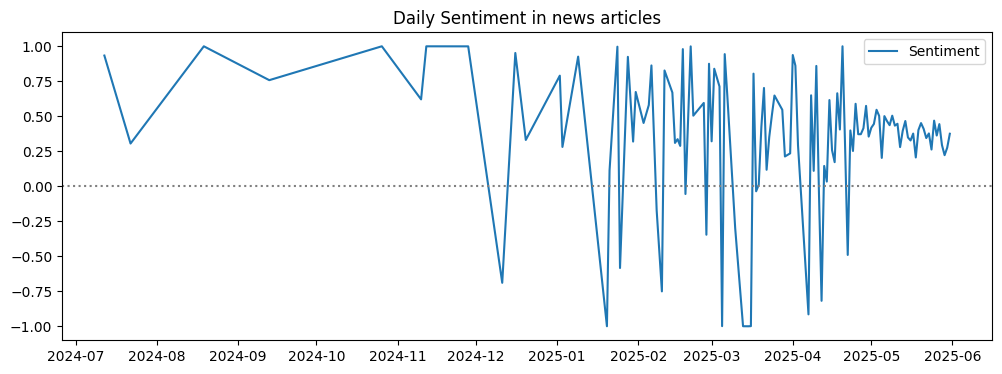

In [41]:
plt.figure(figsize=(12, 4))
plt.title('Daily Sentiment in news articles')
plt.plot(df_news_by_day.index, df_news_by_day, label='Sentiment')
plt.axhline(y=0, color='gray', linestyle=':')
plt.legend()

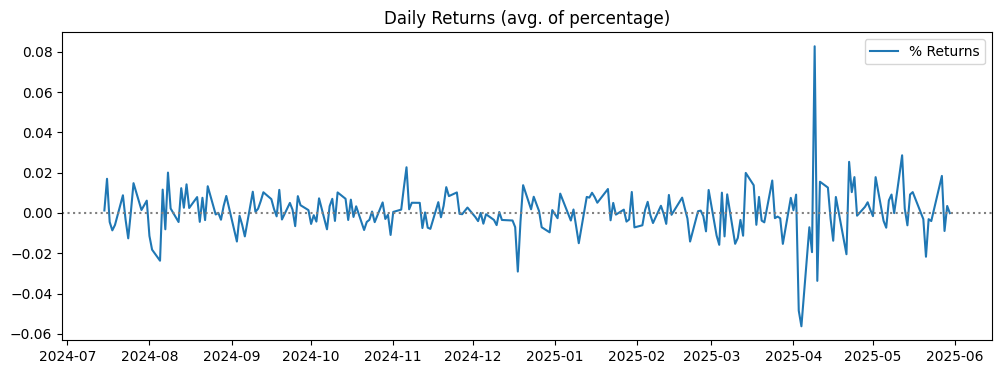

In [60]:
plt.figure(figsize=(12, 4))
plt.title('Daily Returns (avg. of percentage)')
plt.plot(daily_returns.index, daily_returns, label='% Returns')
plt.axhline(y=0, color='gray', linestyle=':')
plt.legend()

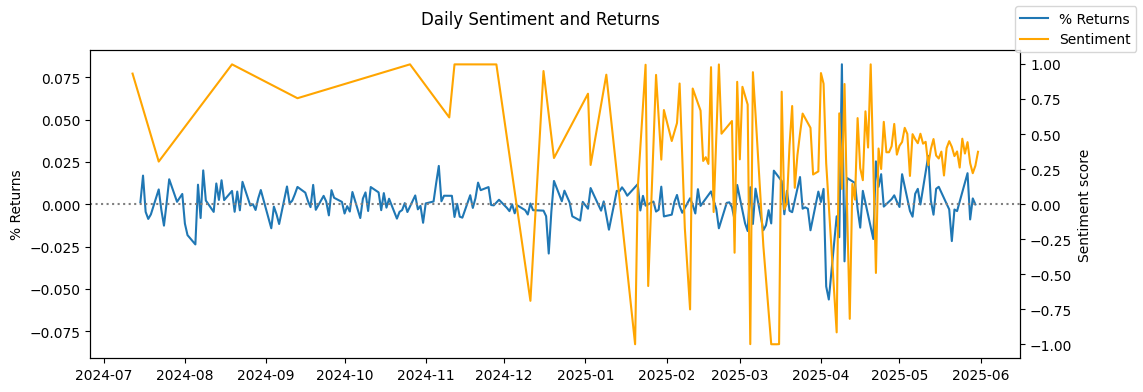

In [128]:
fig, ax = plt.subplots(figsize=(12, 4))

fig.suptitle('Daily Sentiment and Returns')

ax.plot(daily_returns.index, daily_returns, label='% Returns')
ax.set_ylabel('% Returns')

ax2 = ax.twinx()
ax2.plot(df_news_by_day.index, df_news_by_day, label='Sentiment', color='orange')
ax2.set_ylabel('Sentiment score')

# This helps ensure the 0 is aligned on both axis
range_daily_returns = max(daily_returns.max(), abs(daily_returns.min())) * 1.1
ax.set_ylim(-range_daily_returns, range_daily_returns)

range_sentiment = max(df_news_by_day.max(), abs(df_news_by_day.min())) * 1.1
ax2.set_ylim(-range_sentiment, range_sentiment)

ax.axhline(y=0, color='gray', linestyle=':')
fig.legend()

## Compare Daily Portfolio Value Against Daily Average Sentiment

In this section, you will simulate a simple market portfolio and explore how its performance aligns with daily sentiment scores.

👉 **Instructions**:

1. Simulate a **market portfolio** by computing the cumulative return of the average daily return across all tickers.
2. Start the portfolio with an **initial value of 1.0** and track its value over time.
3. Plot the **daily average sentiment** and the **portfolio value** using a dual-axis line chart.

✅ This visualization lets you explore whether market sentiment leads or lags behind portfolio movements.

> ℹ️ Think about how this setup could inform a basic trading strategy—or whether sentiment could serve as a timing signal.


In [80]:
cumulative_returns = daily_returns.cumsum()

In [120]:
def simulate_portfolio(cumulative_returns, initial_value=1.0):
    portfolio_value = [initial_value]

    # Skip the first item since there are no returns yet in the first day.
    for returns in cumulative_returns[1:]:
        portfolio_value.append(initial_value * (1 + returns))

    return portfolio_value

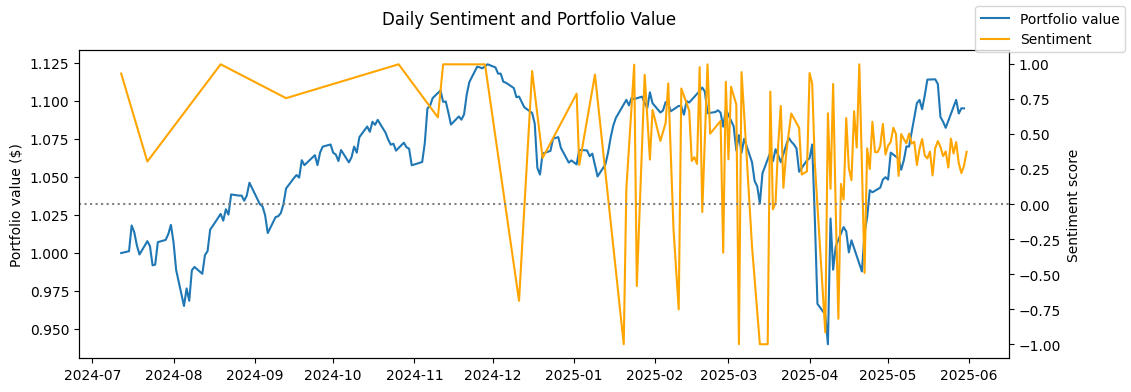

In [137]:
fig, ax = plt.subplots(figsize=(12, 4))

fig.suptitle('Daily Sentiment and Portfolio Value')

ax.plot(daily_returns.index, simulate_portfolio(cumulative_returns), label='Portfolio value')
ax.set_ylabel('Portfolio value ($)')

ax2 = ax.twinx()
ax2.plot(df_news_by_day.index, df_news_by_day, label='Sentiment', color='orange')
ax2.set_ylabel('Sentiment score')

ax2.axhline(y=0, color='gray', linestyle=':')
fig.legend()

## Compute Sector-Level Sentiment and Returns

In this section, you’ll analyze how sector-level news sentiment compares to market performance for May. You’ll also measure whether sentiment correlates with returns.

👉 **Instructions**:

1. Group companies by **sector** using the metadata.
2. For each sector:

   * Compute **monthly average sentiment** (Feb to May).
   * (Optional) Count the number of headlines per month.
3. Compute **monthly stock returns** from price data and extract **May returns**.
4. Build a comparison table with:

   * `SECTOR`
   * `SENTIMENT` (May sentiment)
   * `RETURN` (May return)
5. Compute and print the **correlation** between May sentiment and May returns.

✅ This step helps evaluate whether optimistic news coverage for a sector is associated with better performance.

> 💡 Once your analysis is complete, consider:
>
> * Which sectors *looked* good in the news but didn’t perform?
> * Which sectors performed well despite neutral/negative sentiment?
> * Would you invest based on sentiment alone? Why or why not?



In [149]:
sectors = list(df_meta['SECTOR'].unique())

df_news_with_meta = df_news.merge(df_meta, on='TICKER')

In [231]:
# Filtering feb to may
df_news_with_meta = df_news_with_meta.where(
    (df_news_with_meta['PUBLICATION_DATE'].dt.month >= 2) &
    (df_news_with_meta['PUBLICATION_DATE'].dt.month <= 5)
)

df_news_with_meta['MONTH'] = df_news_with_meta['PUBLICATION_DATE'].dt.month

df_news_by_month_sector = df_news_with_meta.groupby(
    ['SECTOR', df_news_with_meta['MONTH']],
)['SENTIMENT'].mean()

display("Average sentiment by sector and month")
display(df_news_by_month_sector)

'Average sentiment by sector and month'

SECTOR                  MONTH
Basic Materials         2.0     -0.742752
                        3.0      0.289672
                        4.0     -0.019181
                        5.0      0.408552
Communication Services  3.0      0.939103
                        4.0      0.830529
                        5.0      0.238348
Consumer Cyclical       2.0      0.066176
                        3.0     -0.618238
                        4.0      0.444770
                        5.0      0.265969
Consumer Defensive      3.0     -0.123237
                        4.0      0.057726
                        5.0      0.167070
Energy                  3.0     -0.293474
                        4.0      0.255317
                        5.0      0.341167
Financial Services      2.0     -0.041702
                        3.0      0.477714
                        4.0      0.364253
                        5.0      0.348040
Healthcare              2.0      0.080483
                        4.0      0.192087
                        5.0      0.357050
Industrials             2.0      0.603356
                        3.0     -0.001458
                        4.0      0.079986
                        5.0      0.354862
Real Estate             2.0      0.750933
                        3.0      0.358941
                        4.0      0.515152
                        5.0      0.547486
Technology              3.0      0.489588
                        4.0      0.599422
                        5.0      0.408007
Utilities               2.0      0.711542
                        3.0      0.262174
                        4.0      0.430407
                        5.0      0.504931
Name: SENTIMENT, dtype: float64

In [210]:
display("News articles by sector and month")
display(df_news_with_meta.groupby(
    ['SECTOR', df_news_with_meta['MONTH']],
)['SENTIMENT'].count())

'News articles by sector and month'

SECTOR                  MONTH
Basic Materials         2.0        1
                        3.0        4
                        4.0       10
                        5.0      135
Communication Services  3.0        1
                        4.0        5
                        5.0      144
Consumer Cyclical       2.0        3
                        3.0        4
                        4.0       18
                        5.0      409
Consumer Defensive      3.0        1
                        4.0       10
                        5.0      270
Energy                  3.0        1
                        4.0       12
                        5.0      172
Financial Services      2.0        7
                        3.0        9
                        4.0      111
                        5.0      453
Healthcare              2.0        2
                        4.0        5
                        5.0      446
Industrials             2.0        6
                        3.0        2
                        4.0       19
                        5.0      539
Real Estate             2.0        2
                        3.0        6
                        4.0       59
                        5.0      188
Technology              3.0        5
                        4.0       23
                        5.0      636
Utilities               2.0        5
                        3.0        1
                        4.0       20
                        5.0      209
Name: SENTIMENT, dtype: int64

In [369]:
may_prices = stock_history[stock_history.index.month == 5]

# Similar as with daily returns, we first compute the return by individual tickers
may_daily_returns = may_prices['Close'].pct_change()

# Because we want the returns for the whole month, we get the cumulative returns at the last day of the month
may_returns = may_daily_returns.cumsum().loc[[may_daily_returns.index.max()]]

# Finally, we merge with the metadata df to be able to aggregate the monthly returns by the ticker sector
returns_by_sector = may_returns.melt(ignore_index=False).join(
    df_meta.set_index('TICKER'), on='Ticker').groupby('SECTOR').value.mean()

display(returns_by_sector)


,value
SECTOR,
Basic Materials,0.030165
Communication Services,0.042682
Consumer Cyclical,0.058701
Consumer Defensive,0.013755
Energy,0.024186
Financial Services,0.063696
Healthcare,0.016648
Industrials,0.069616
Real Estate,0.005955


In [373]:
df_sentiment_return = pd.DataFrame(df_news_by_month_sector.loc[:,5])

df_sentiment_return['RETURN (%)'] = returns_by_sector.values * 100

display(df_sentiment_return)

,SENTIMENT,RETURN (%)
SECTOR,,
Basic Materials,0.408552,3.016519
Communication Services,0.238348,4.268173
Consumer Cyclical,0.265969,5.870126
Consumer Defensive,0.167070,1.375500
Energy,0.341167,2.418602
Financial Services,0.348040,6.369596
Healthcare,0.357050,1.664842
Industrials,0.354862,6.961648
Real Estate,0.547486,0.595507


In [374]:
df_sentiment_return.corr()

,SENTIMENT,RETURN (%)
SENTIMENT,1.000000,-0.145984
RETURN (%),-0.145984,1.000000


### **Question 1.** Which sectors *looked* good in the news? How did they perform?


The sectors with the highest sentiment scores were:
- Real Estate: Despite leaning towards positive sentiment (score=~0.54), the ROI for the sector during May 2025 was the lowest of all categories at ~0.59%.
- Utilities: Mostly neutral sentiment (score=~0.50) and modest returns at ~2.88%

### **Question 2.** Which sectors performed well despite neutral/negative sentiment?


Technology comes to mind, with the highest ROI of all sectors at ~7.49%, but a neutral sentiment, leaning towards the negative end at ~0.40.

Industrials, Financial Services, and Consumer Cyclical sectors also performed very well despite their sentiment, with ROIs of ~6.96%, ~6.36%, and ~5.87%, and sentiment scores of ~0.35, ~0.34, and ~0.26, respectively

### **Question 3.**  Would you invest based on sentiment alone? Why or why not?

I wouldn't. At least based on this exercise, sentiment does not appear to be a clear signal of stock value changes, either positive or negative. From this exercise alone, it even had a negative (albeit weak) correlation.

Another thing to consider is that negative public perception does not necessarily mean a bad performance for a stock. For example, news about layoffs at tech companies represent bad optics for the company, but most of the times they result in increased stock value for shareholders. This could be one of the reasons why the Technology sector is such an outlier in terms of ROI vs. news sentiment.

That said, it's also worth noting that all of our sectors had positive returns and neutral to positive average sentiment scores. This means that May was a good overall month for the market, as can be seen in the portfolio simulation chart. It's possible that if this exercise were to be repeated with another month, the outcome and conclusions may change.

### **Question 4.**  How would you go about testing a sentiment analysis strategy in a more robust way?

For starters, I would try to incorporate as much data as I could, both for periods with strong and weak performance.

Another option would be to tweak the premises and hypothesis used for the NLI model, which could change the sentiment classification for each article.

For example, we could integrate the ticker symbol as part of the premise (e.g. "the following is a news article related to the {ticker} company"), and modify the hypothesis to state explicitly that we care about the sentiment for the specific ticker (e.g. "the news will impact the price of {ticker} positively").

This could help improve classification for articles mentioning more than one company, while also integrating more context for the encoder to understand that we care about stock price and not necessarily the public perception.

Lastly, I would want to repeat this experiment for periods with strongly negative news sentiment, and compare it with strongly positive sentiment. As mentioned, when we compared sentiment and value in May, since most news were neutral to positive they didn't appear to have much of an impact.

However, when we compared the simulated portfolio value with the news sentiment, it is apparent that periods with strongly negative news sentiment do tend to lower the portfolio value. While this is just an observation based on the generated chart, it may indicate that strongly negative news have more of an impact on stock price than neutral or strongly positive news.